In [ ]:
from datasets import SinusoidDataset
from models import MLPCNF
from lightning import Trainer
from lightning.pytorch.callbacks import RichModelSummary

In [2]:
dataset = SinusoidDataset()
model = MLPCNF(
    dim=len(dataset.parameter_names),
    obs_dim=len(dataset.observation_times),
    hidden_dim=512,
    depth=4,
    lr=1e-4,
)
# model = torch.compile(model)

train_dataloader = dataset.dataloader(
    batch_size=1024,
    batches=1024,
    num_workers=8,
    persistent_workers=True,
    pin_memory=True,
)
trainer = Trainer(
    devices='1,',
    max_epochs=20,
    callbacks=[RichModelSummary()],
)
trainer.fit(model, train_dataloader)

Trainer already configured with model summary callbacks: [<class 'lightning.pytorch.callbacks.rich_model_summary.RichModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA RTX A6000') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2]


┏━━━┳━━━━━━┳━━━━━━┳━━━━━━━━┓
┃   ┃ Name ┃ Type ┃ Params ┃
┡━━━╇━━━━━━╇━━━━━━╇━━━━━━━━┩
│ 0 │ flow │ MLP  │  803 K │
└───┴──────┴──────┴────────┘

Trainable params: 803 K                                                                                            
Non-trainable params: 0                                                                                            
Total params: 803 K                                                                                                
Total estimated model params size (MB): 3

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=20` reached.


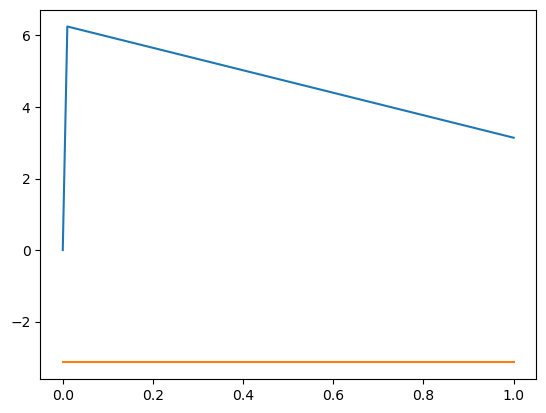

In [27]:
import jax
import jax.numpy as jnp
from jax.scipy.stats import uniform
import matplotlib.pyplot as plt


x0 = jnp.zeros(())
x1 = jnp.ones(()) *3*jnp.pi 
t = jnp.linspace(0, 1, 100)

@jax.value_and_grad
def geodesic(t, x0, x1):
    logmap = jnp.arctan2(jnp.sin(x1 - x0), jnp.cos(x1 - x0))
    xt = (x0 + t * logmap) % (2 * jnp.pi)  # exponential map
    return xt

xt, dx = jax.vmap(lambda t: geodesic(t, x0, x1))(t)
plt.plot(t, xt)
plt.plot(t, dx)

  0%|          | 0/5 [00:00<?, ?it/s]

/home/davide_sartor/CANNA/priors.py:77: RuntimeWarning: invalid value encountered in log
  return np.where(
/home/davide_sartor/CANNA/priors.py:77: RuntimeWarning: invalid value encountered in log
  return np.where(
/home/davide_sartor/CANNA/priors.py:77: RuntimeWarning: invalid value encountered in log
  return np.where(
/home/davide_sartor/CANNA/priors.py:77: RuntimeWarning: invalid value encountered in log
  return np.where(


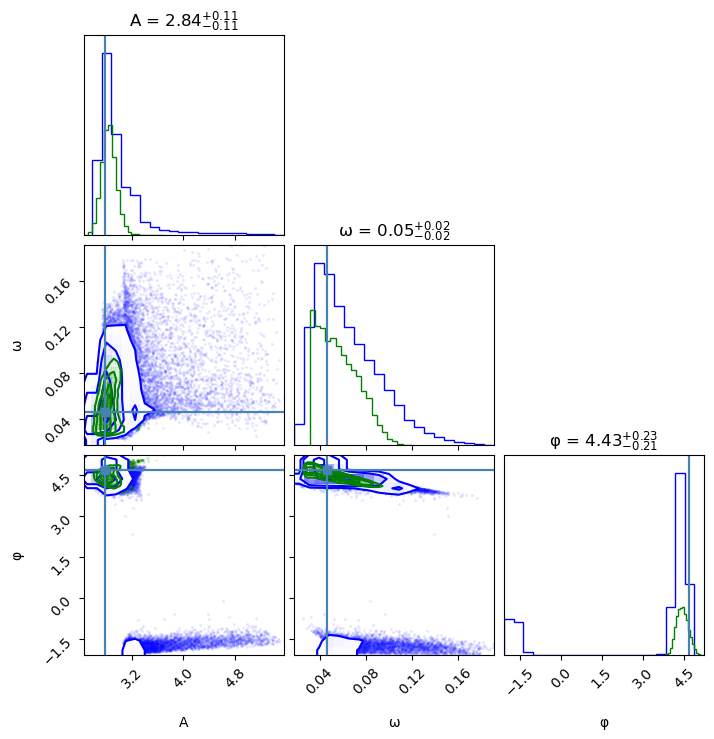

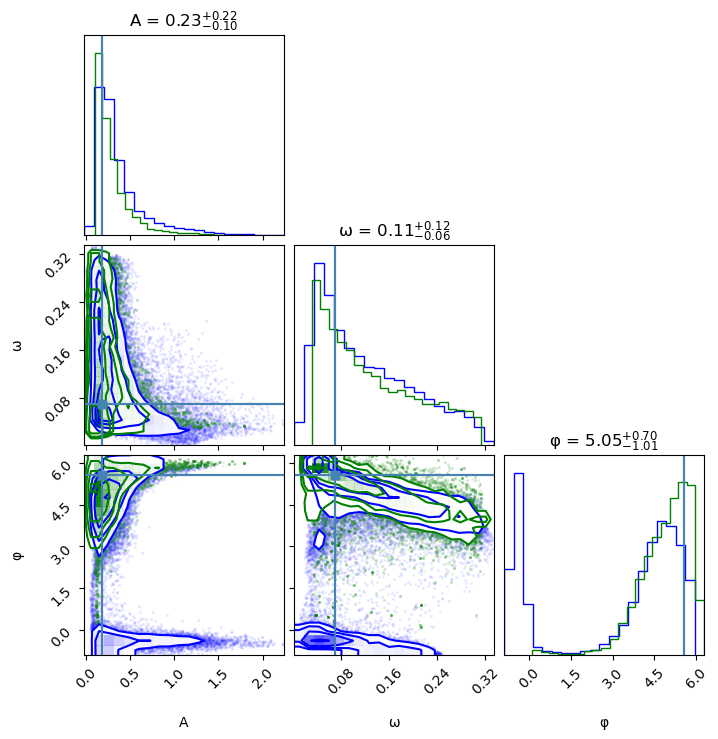

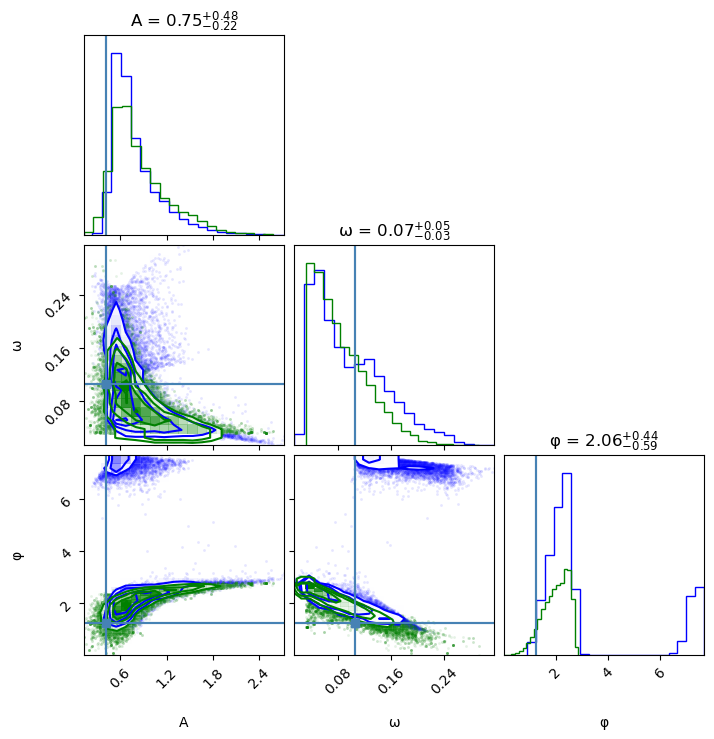

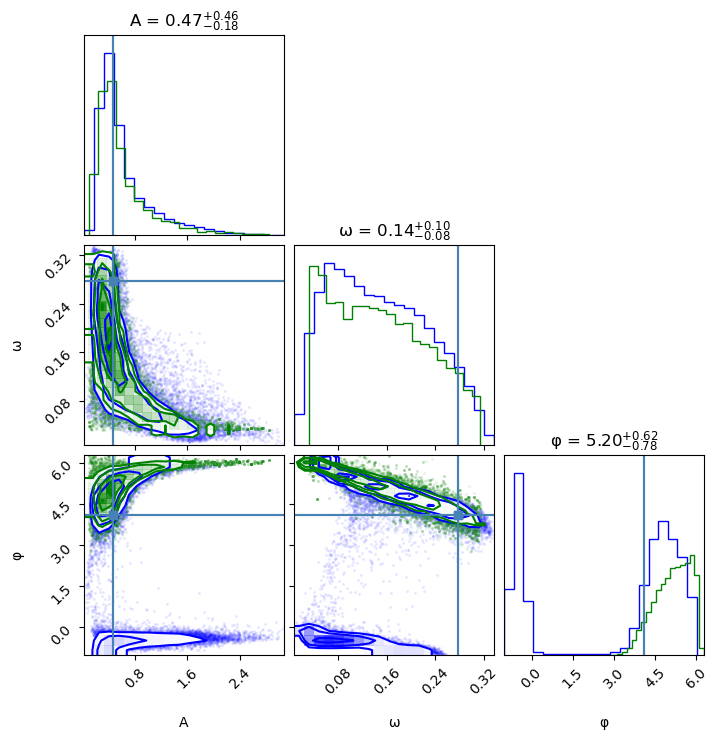

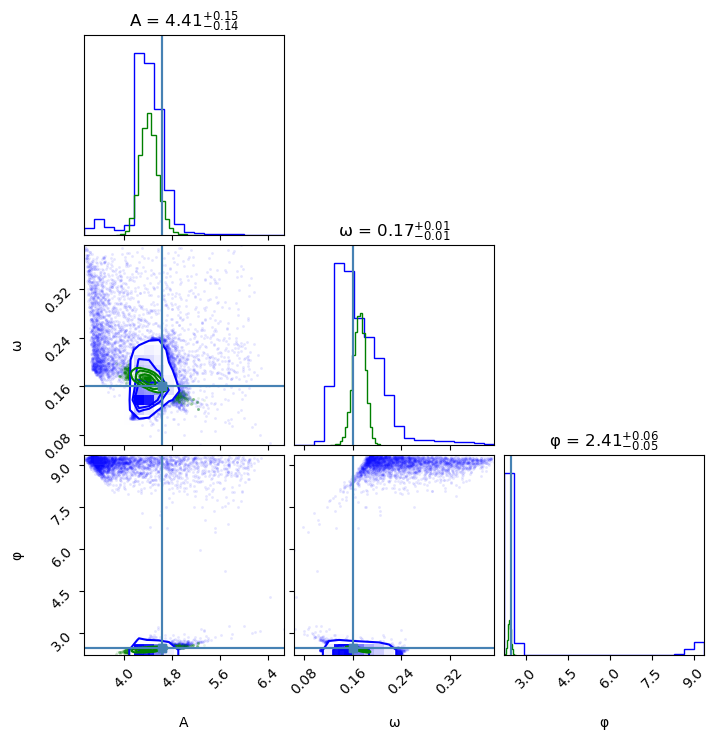

In [3]:
from utils import corner_plot
corner_plot(dataset, model.to("cuda"), examples=5, samples=32*1024, verbose=True)

In [21]:
from datasets import SinusoidDataset
import treescope
senino=SinusoidDataset(observation_time=1024)
#treescope.display(senino,autovisualize=True)

import jax.random as jr
porcodio=senino.train_batch(rng=jr.key(42),batch_size=10)
print(porcodio)

(Array([0.6963757 , 0.10630417, 0.9822235 , 0.5450225 , 0.50055265,
       0.52208424, 0.9615474 , 0.46601856, 0.6295512 , 0.38333416],      dtype=float32), Array([[-0.1635645 , -0.02468443, -0.4913261 , -0.8709757 ],
       [-0.8544416 , -0.1705463 , -0.9837524 ,  0.17953043],
       [-0.33885235, -0.71402425,  0.40281677,  0.91528064],
       [ 0.3065256 , -0.38360292, -0.3776693 ,  0.9259405 ],
       [ 0.34705603,  0.4293058 ,  0.0880921 , -0.99611235],
       [-0.34020782,  0.49700212,  0.99863434,  0.05224467],
       [ 0.25475788,  0.9058349 , -0.14538394,  0.9893753 ],
       [ 0.6051518 ,  0.31718338, -0.7561139 ,  0.6544401 ],
       [ 0.31737268, -0.60596335, -0.2596478 ,  0.96570337],
       [ 0.11293364,  0.39863646, -0.95673984, -0.29094476]],      dtype=float32), Array([[ 0.55925035, -0.4320556 ,  2.1640165 , -1.2207433 ],
       [ 0.8394901 , -0.6388309 , -0.23205952, -1.2715901 ],
       [ 0.5880735 , -1.7131753 ,  1.0811031 , -0.47579557],
       [-0.59264225, -0.6868

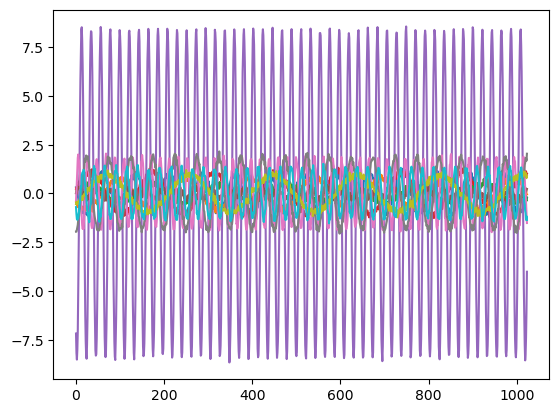

In [33]:
from matplotlib import pyplot as plt
for t, xt, dx, y in zip(*porcodio):
    plt.plot(y)

(Array([0.6963757 , 0.10630417, 0.9822235 , 0.5450225 , 0.50055265,
        0.52208424, 0.9615474 , 0.46601856, 0.6295512 , 0.38333416],      dtype=float32),
 Array([[-0.1635645 , -0.02468443, -0.4913261 , -0.8709757 ],
        [-0.8544416 , -0.1705463 , -0.9837524 ,  0.17953043],
        [-0.33885235, -0.71402425,  0.40281677,  0.91528064],
        [ 0.3065256 , -0.38360292, -0.3776693 ,  0.9259405 ],
        [ 0.34705603,  0.4293058 ,  0.0880921 , -0.99611235],
        [-0.34020782,  0.49700212,  0.99863434,  0.05224467],
        [ 0.25475788,  0.9058349 , -0.14538394,  0.9893753 ],
        [ 0.6051518 ,  0.31718338, -0.7561139 ,  0.6544401 ],
        [ 0.31737268, -0.60596335, -0.2596478 ,  0.96570337],
        [ 0.11293364,  0.39863646, -0.95673984, -0.29094476]],      dtype=float32),
 Array([[ 0.55925035, -0.4320556 ,  2.1640165 , -1.2207433 ],
        [ 0.8394901 , -0.6388309 , -0.23205952, -1.2715901 ],
        [ 0.5880735 , -1.7131753 ,  1.0811031 , -0.47579557],
        [-0.59